In [1]:
import sys

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go

import utils.data_processing as dp
import utils.conversion as conv

import copy

from tqdm import tqdm

from plot_config import *

In [2]:
df_V45 = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thèse VDE\Manuscrit\Chapter_PL\TUV_PL_results_V4.5_V4.6.xlsx', sheet_name = "V4.5_glycol")
df_V46 = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thèse VDE\Manuscrit\Chapter_PL\TUV_PL_results_V4.5_V4.6.xlsx', sheet_name = "V4.6_glycol")

df_V45['Q'] = df_V45['Vdot'].apply(lambda x: conv.convert_flow_rate(x, 'L/h', 'm3/s'))
df_V45 = df_V45.loc[df_V45['Vdot'] > 0]
df_V45.sort_values(by = 'Vdot', inplace = True)
df_V45.reset_index(drop = True, inplace = True)

# shortened
df_V45 = df_V45.iloc[[2,5,7,9,11]]

In [3]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.5.xlsx"
hw, par, cond = fe.initialize(path, file_name)

fluid = {'name':'MPG','glycol_rate':0.4}
T_op = 23
p = 1

rho_op = PropsSI('D', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))
mu_op = PropsSI('V', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))

fe.change_fluid(cond, fluid)
fe.change_temperature(cond, conv.to_K(T_op), fluid)

# tabl, res, PL, residuals = modf.PL_fsolve(par, cond) 

In [4]:
D_tuy = 38.5e-3
A_tuy = math.pi * (D_tuy/2)**2
D_fit = 15e-3
A_fit = math.pi * (D_fit/2)**2
D_man = 18e-3
A_man = math.pi * (D_man/2)**2

bend_angle = 90
bend_radius = 40e-3 # m
L_unimpeded = 50e-3
L_linear_after_bend = 55e-3

In [5]:
df_V45['inlet_first_contraction'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_tuy, Di2=D_fit, Re = fds.core.Reynolds(V=x/A_tuy, D=D_tuy, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_tuy))

df_V45['inlet_bend_in_fitting'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K=fds.fittings.bend_rounded(Di=D_fit, angle=bend_angle, rc = bend_radius, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op),L_unimpeded=L_unimpeded),
                                                                            rho = rho_op,
                                                                            V = x/A_fit))

df_V45['inlet_linear_after_bend'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.K_from_f(fds.friction.friction_factor(Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)), L=L_linear_after_bend, D=D_fit),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df_V45['inlet_first_expansion'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.diffuser_sharp(Di1=D_fit, Di2=D_man, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df_V45['before_hx'] = df_V45['inlet_first_contraction'] + df_V45['inlet_bend_in_fitting'] + df_V45['inlet_linear_after_bend'] + df_V45['inlet_first_expansion']

df_V45['outlet_first_contraction'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_man, Di2=D_fit, Re = fds.core.Reynolds(V=x/A_man, D=D_man, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_man))
df_V45['outlet_first_expansion'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.diffuser_sharp(Di1=D_fit, Di2=D_tuy, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df_V45['before_hx'] = df_V45['inlet_first_contraction'] + df_V45['inlet_bend_in_fitting'] + df_V45['inlet_linear_after_bend'] + df_V45['inlet_first_expansion']
df_V45['after_hx'] = df_V45['outlet_first_contraction'] + df_V45['inlet_bend_in_fitting'] + df_V45['inlet_linear_after_bend'] + df_V45['outlet_first_expansion']
df_V45['both_singular'] = df_V45['before_hx'] + df_V45['after_hx']
df_V45['singular_proportion'] = df_V45['both_singular'] / df_V45['PL']

In [6]:
res_dict = {}
PL_res = []

for Vdot in tqdm(df_V45['Vdot'], total = len(df_V45['Vdot'])):
    fe.change_Vdot(cond, Vdot)
    tabl, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

    res_dict[Vdot] = {'tabl' : copy.deepcopy(tabl),
                      'PL' : PL,
                      'df_PL' : copy.deepcopy(df_PL),
                      'residuals' : copy.deepcopy(residuals)}

    PL_res.append(PL)

100%|██████████| 5/5 [00:24<00:00,  4.95s/it]


In [7]:
df_V45['PL_hx_model'] = np.array(PL_res)/1000
df_V45['PL_tot_model'] = df_V45['PL_hx_model'] + df_V45['both_singular']

df_V45['ratio'] = df_V45['PL_tot_model'] / df_V45['PL']

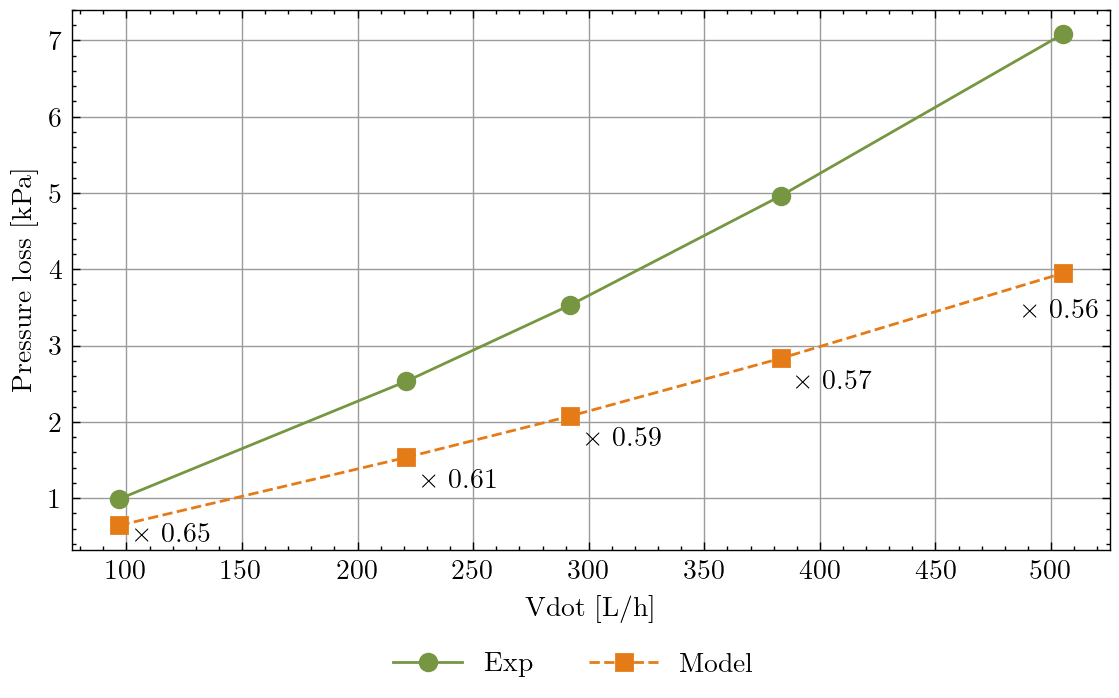

In [8]:
# Assuming rconfig.wcol_in and rconfig.hfig are defined correctly in your setup
fig, ax1 = plt.subplots(figsize=(rconfig.wcol_in, rconfig.hfig(0.3, unit="in")))

ax1.plot(df_V45['Vdot'], df_V45['PL'], label='Exp',
                                            color=colors[0],
                                            linestyle=linestyles[0],
                                            marker=markers[0],
)

# Scatter plot with Model and Experimental data
ax1.plot(df_V45['Vdot'], df_V45['PL_tot_model'], label='Model',
                                                    color=colors[1],
                                                    linestyle=linestyles[1],
                                                    marker=markers[1],
)   

# Annotate each model data point with the ratio of PL / PL_tot_model
for i, (x, y, ratio) in enumerate(zip(df_V45['Vdot'], df_V45['PL_tot_model'], df_V45['ratio'])):
    if i == 0:
        x_pos, y_pos = 20, -5
    elif i == len(df_V45['Vdot']) - 1:
        x_pos, y_pos = 0, -15
    else:
        x_pos, y_pos = 20, -10
    ax1.annotate(rf"$\times$ {ratio:.2f}", (x, y), textcoords="offset points", xytext=(x_pos, y_pos), ha='center')

# Customizing grid and adding legend
ax1.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), ncol=2, frameon=False, handlelength=2.5)

ax1.set_xlabel('Vdot [L/h]')
ax1.set_ylabel('Pressure loss [kPa]')

# Show the plot
plt.show()


In [ ]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_PL\PL_V4.5_TUV_vs_1D.png', dpi=600)

In [ ]:
dp.write_pickle(r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis\1D_CFD_TUV','V4.5_1D_simple', df_V45)

In [ ]:
plt.plot(tabl.index, tabl['qx']/(tabl['qx'].sum()/304))

### Parametric

In [9]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.5.xlsx"
hw, par, cond = fe.initialize(path, file_name)

In [11]:
D_cao = hw.riser.D

In [12]:
D_cao

0.002333333333333333

In [25]:
parametric = {}

Dh_riser_range = [0.8*0.002333,0.9*0.002333,0.002333]

for Dh in tqdm(Dh_riser_range, total = len(Dh_riser_range)):

    hw.change_riser_diameter(Dh)
    par = hw.make_dict()

    res_dict = {}
    PL_res = []

    for Vdot in df_V45['Vdot']:
        fe.change_Vdot(cond, Vdot)
        tabl, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

        res_dict[Vdot] = {'tabl' : copy.deepcopy(tabl),
                        'PL' : PL,
                        'df_PL' : copy.deepcopy(df_PL),
                        'residuals' : copy.deepcopy(residuals)}

        PL_res.append(PL)

    parametric[Dh] = {
                        'res_dict' : copy.deepcopy(res_dict),
                        'PL_res' : copy.deepcopy(PL_res)
                        }

100%|██████████| 3/3 [01:18<00:00, 26.33s/it]


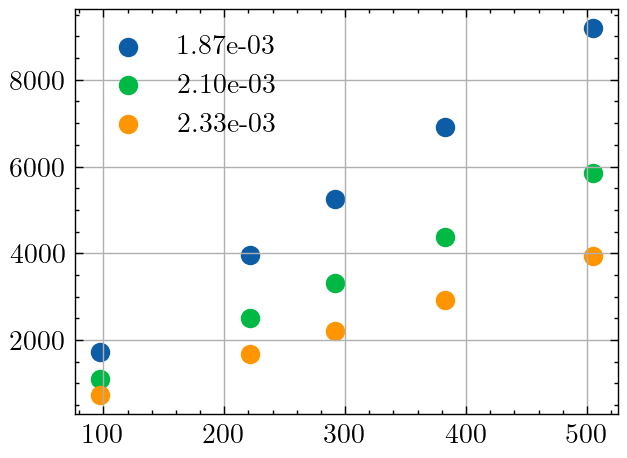

In [27]:
for i, Dh in enumerate(Dh_riser_range):

    # if i <= len(Dh_riser_range) - 7:
    if i <= 1000:

        PL_res = parametric[Dh]['PL_res'] + df_V45['both_singular'].values

        plt.scatter(df_V45['Vdot'], PL_res, label = f'{Dh:.2e}')

plt.legend()
plt.grid()